# A simple Product Recommendation process basd on product descriptions

### Goal of the project

Given an amazon product description, I'm trying to see how what products will be 'recommended'. For example, if I'm purchasing a Banana Republic t-shirt, I want to see if the recommendation system just recommends other t-shirts or/and other Banana Republic products. For simplicity, I'll first visually inspect the results and then analyze results based on the descriptions.  The original metadata file had information on more than 1.5 million products. This json file has products from the "Clothing, Shoes and Jewelry" category. For this exercise, I'm using information from just 40000 products. 

### Motivation for this project

Any decent practical product recommender system will have been trained using a state-of-the-art deep learning architecture and with data from millios of products. What's more? Products evolve over time. Companies do away woth old products and try to promote new ones. This means they'll probably have to reinvent the wheel every now and then. They would have to obtain new reliable data, preprocess it and then train the model and evalute it's performance. 

But in this exercise, I'll try to obtain practical recommendations for products with absolutly no training at all. Sounds too good to be true? You're probably wondering where/how the magic happens. All I'm doing is transforming the descriptions of products using tf-idf vectorizer followed by computing their relative closeness (This step doesn't involve any modeling/using a complex deep learning architecture). Also,the time taken to compute the cosine similarities matrix was negligible.

But enough talk now. Let's get to business and see how this could work like a practical recommendation system!!!

### Practical application

Now, would something like be practical for a large e-commerce company like Amazon? Probably not! They have the resources and architecture to make sure that their recommender system(s) don't go out of date. They wouldn't have a problem gathering data from millions of products. After all, it's not practical to compute the cosine similarities of tens of millions of products each day!

So how could something like this be used? Small scale e-commerce/retail companies probably don't have millions of products. They may have a few 1000 / 100k products. That's certainly not enough data to train a state of the art model. Even if they are able to obtain enough data and come up with a well functioning model, they may not have the time and resources to keep updating the model to adjust to a rapidly changing market. But they could still come up with a neat recommender system if they have their product information in a file or a database. Their tradeoff would be the computation of the similarities matrix every time a product is outdated or a new one is added. For tens of thousands of images, the time taken to compute the similarities matrix is negligible. PS: It took me just around 3 minutes to compute the cosine similarities mareix for over 40000 product descriptions.

<font color='maroon'>

### Outline of the entire process:

1) Read the preprocessed amazon products file.

2) Transform the descriptions in the file using tf-idf vectorization by ignoring all stop words.

3) Transform the tf-idf vector to a numpy array.

4) Compute the relative cosine similarities matrix for all the product descriptions.

5) Given a product, I'll try to find the nine closest products. This will be determined by the magnitude of the computed  relative cosine similarities.

6) Using the 'imUrl' field in the preprocessed metadata file, we'll plot each of the 9 relatd products that are recommended.
</font>

In [1]:
import pandas as pd
import json
import ast
import urllib.request
import numpy as np
import cv2
import matplotlib.pyplot as plt
from sklearn.metrics.pairwise import cosine_similarity

In [2]:
import tensorflow as tf
import tensorflow_hub as hub

/home/adityajakka/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [3]:
import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     /home/adityajakka/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [4]:
from nltk.corpus import stopwords
stop = stopwords.words('english')

### STEP 1

In [5]:
new_df = pd.read_csv('Clothing_file.csv')

In [6]:
#Inspecting the structure of the file
new_df.head()

Unnamed: 0                                              imUrl  \
0           0  http://ecx.images-amazon.com/images/I/41Nrta6E...   
1           1  http://ecx.images-amazon.com/images/I/419ED1sp...   
2           2  http://ecx.images-amazon.com/images/I/41qcR5%2...   
3           3  http://ecx.images-amazon.com/images/I/21hY4FKm...   
4           4  http://ecx.images-amazon.com/images/I/41IPc6iO...   

                                               title  \
0                Geneva Watch Face for Beading LWF26   
1     Iron Metal Dress Form Mannequin 29&quot; Brown   
2  Moneysworth and Best Shoe Care Neon Sport Lace...   
3    Operator Grade Field Jacket - Coyote Brown - XL   
4  Marquette University - Two-Toned Money Clip - ...   

                                         description  
0  Geneva watch face for beading.  This is a rect...  
1  Wrought Iron Metal Dress Form ~ Mannequin ~ Je...  
2  The colors are orange, lime and white. The col...  
3  The Operator Grade Field Jacket is soon to bec...  
4  Our Marquette University money clip is a hands...

In [7]:
len(new_df)

42685

We will now only choose the fields of interest

In [8]:
new_df = new_df[['imUrl', 'description']]

Dropping rows with NaN values

The index will be reset by ignoring the old indices.

### STEP 2

Now, the 'description' column will be transformed using the TF-IDF vectorizer and english stop words. (Common non-descriptive/non-adjective words 'a', 'and' and 'the' will be ignored. 

In [9]:
new_df['description_new'] = new_df['description'].str.lower().str.replace(',', '').str.replace('.', '').str.replace('  ', ' ').str.replace('\d+', '')

In [10]:
new_df['description_new'].loc[0]

'geneva watch face for beading this is a rectangle silver plated watch face with loops this has a white dial japan movement heavy silver plating and is water resistant the loops can be removed easily with pliers to beading directly to the watch face not including the loops this watch face measures  /" in length and about /" in width stems have been pulled to save battery life'

In [11]:
new_df['description_new'] = new_df['description_new'].apply(lambda x: ' '.join([word for word in x.split() if word not in (stop)]))

In [12]:
new_df['description_new'].loc[0]

'geneva watch face beading rectangle silver plated watch face loops white dial japan movement heavy silver plating water resistant loops removed easily pliers beading directly watch face including loops watch face measures /" length /" width stems pulled save battery life'

In [13]:
module_url = "https://tfhub.dev/google/universal-sentence-encoder/2"

In [14]:
embed = hub.Module(module_url)

INFO:tensorflow:Using /tmp/tfhub_modules to cache modules.


In [15]:
all_descriptions = new_df['description_new'].tolist()

In [16]:
len(all_descriptions)

42685

In [17]:
tf.logging.set_verbosity(tf.logging.ERROR)

In [18]:
with tf.device('/device:CPU:0'):
    with tf.Session() as session:
        session.run([tf.global_variables_initializer(), tf.tables_initializer()])
        description_embeddings = session.run(embed(all_descriptions))

In [19]:
len(description_embeddings)

42685

In [20]:
len(description_embeddings[0])

512

In [21]:
len(description_embeddings[1])

512

### STEP 4

In this step, the relative cosine similarities matrix will be computed. For two duplicate images, the computed cosine similarity is 1. If the images are vastly different from one another, the similarity coefficient will be close to 0. Now, the cosine similarity matrix for just the first three images.

In [22]:
cos_matrix = cosine_similarity(description_embeddings)

In [23]:
cos_matrix.shape

(42685, 42685)

As expected, when a product correlation is computed with itself, 1 is the computed similarity. The first and third products are correlated too. But the magnitude is just ~0.02 which could indicate that they are entirely different products.

Since the relative similarity is computed for each element in the dataset, a square matrix is obtained.

Next, we'll compute the cosine similarities of all the products in our dataset.

In [24]:
words_siilar = cos_matrix

In [25]:
words_siilar.shape

(42685, 42685)

We get a square matrix of size 40333x40333.

In the next cell bock, a simple function has been defined to help retrieve the image url and display the product image.

In [26]:
def get_images(url):          
    resp = urllib.request.urlopen(url)                        # This step read the image from the url
    image = np.asarray(bytearray(resp.read()), dtype='uint8') # The read image is then converted to an array
    image = cv2.imdecode(image, cv2.IMREAD_COLOR)             # The images are read keeping the color (RGB) information intact
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    #new_img = cv2.resize(image, (224,224), interpolation=cv2.INTER_CUBIC)
    return image

In [27]:
def get_related_products(index_num, data = new_df):
    j = 4 #This variable will be used in the subplots for positioning of the related product items
    similar_prod_arr = words_siilar[index_num].argsort()[::-1][:10] # Computes the 9 closes product descriptions based on cosin similarity matrix.
    prod_url = new_df['imUrl'].loc[index_num] # Obtaining the URL of the product image
    prod_img = get_images(prod_url) # Retrieving the image from the URL
    fig, ax = plt.subplots(figsize=(19,14))
    plt.subplot(4,3,2)
    plt.imshow(prod_img) # Plotting the product image
    plt.title('Product Image',fontsize=14, fontweight='bold')
    for i in similar_prod_arr[1:]:
        url = new_df['imUrl'].loc[i] # Retrieving the image URLs of all relatd products.
        img = get_images(url) # Retrieves the images of all items related to the product
        plt.subplot(4,3,j) 
        plt.imshow(img) # Plots the images
        plt.xlabel('Related product index: ' + str(i))
        j+=1

### STEP 6

Let's get started with the fun part already!

Before we begin seeing results right away, let us inspect th product in query.

I've added code to record the index number of the product descriptions.

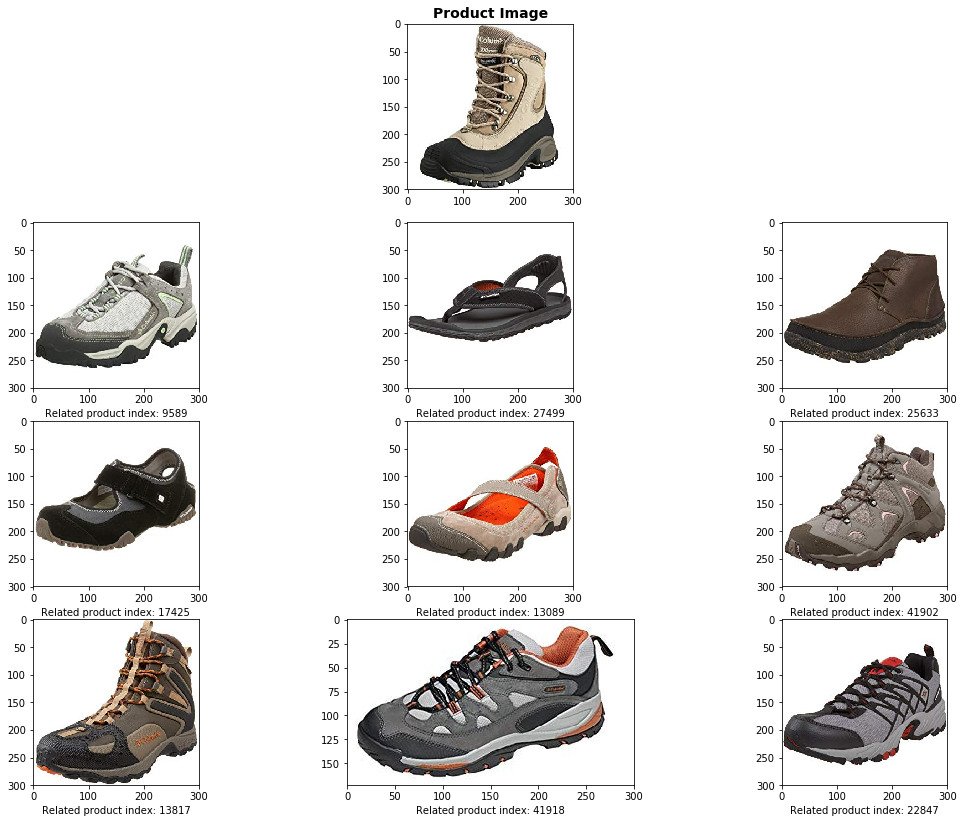

In [28]:
get_related_products(1781)

Let's move on to the next product

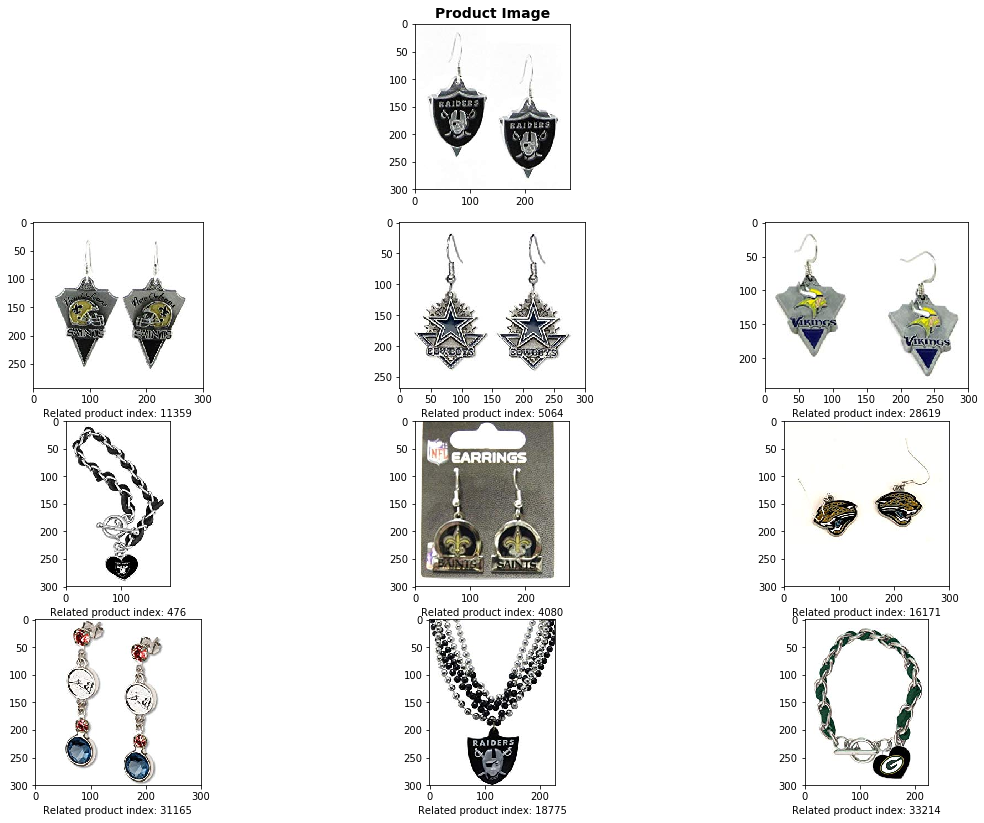

In [29]:
get_related_products(6179)

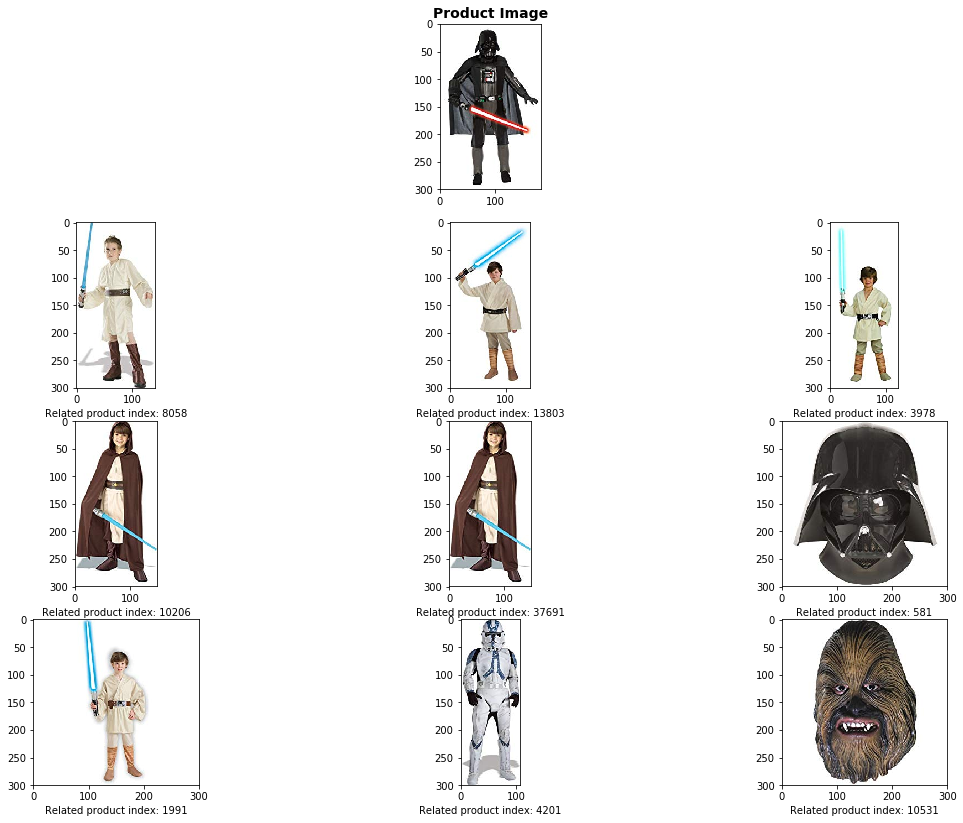

In [31]:
get_related_products(26123)

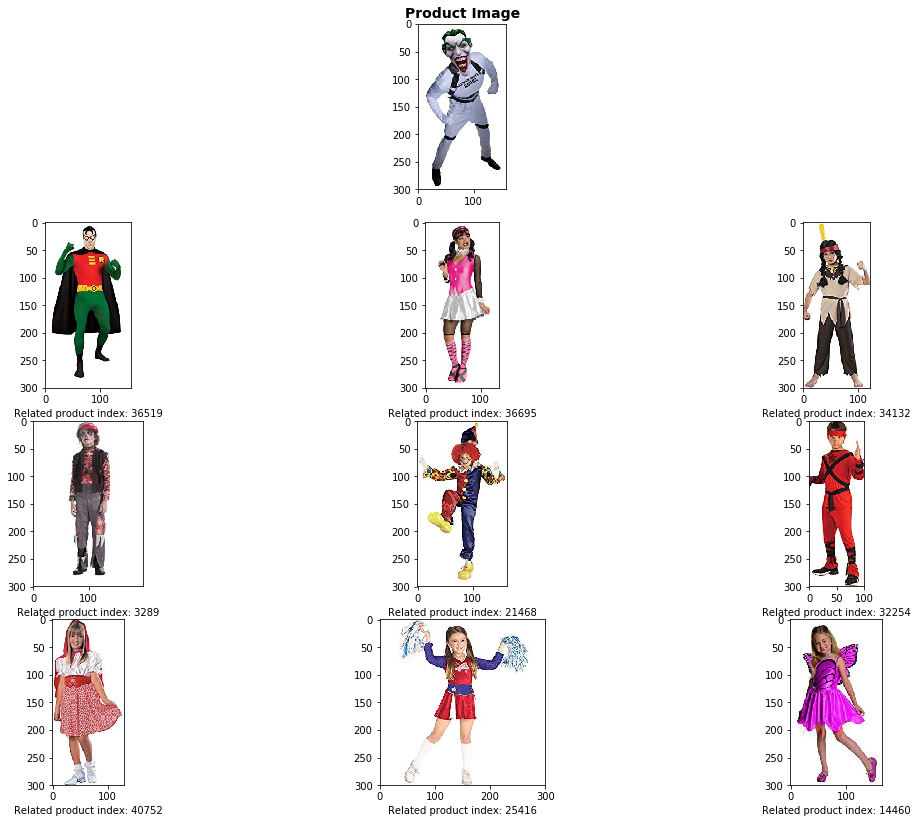

In [32]:
get_related_products(762)

We get other mpvie themed costumes but only one of them seems to be from Star Wars. Let's see if the rest are from Rubie's.

Cherry picking a few descriptions, they indeed seem to be from **Rubie's Costume Company**.

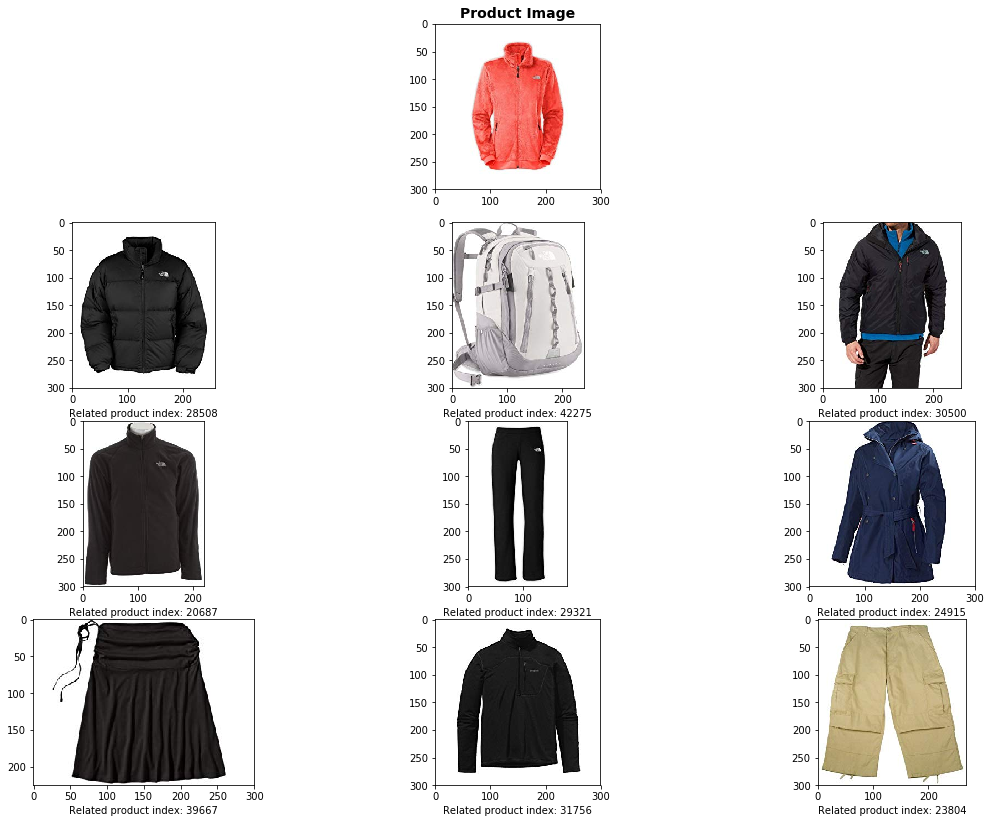

In [33]:
get_related_products(13859)

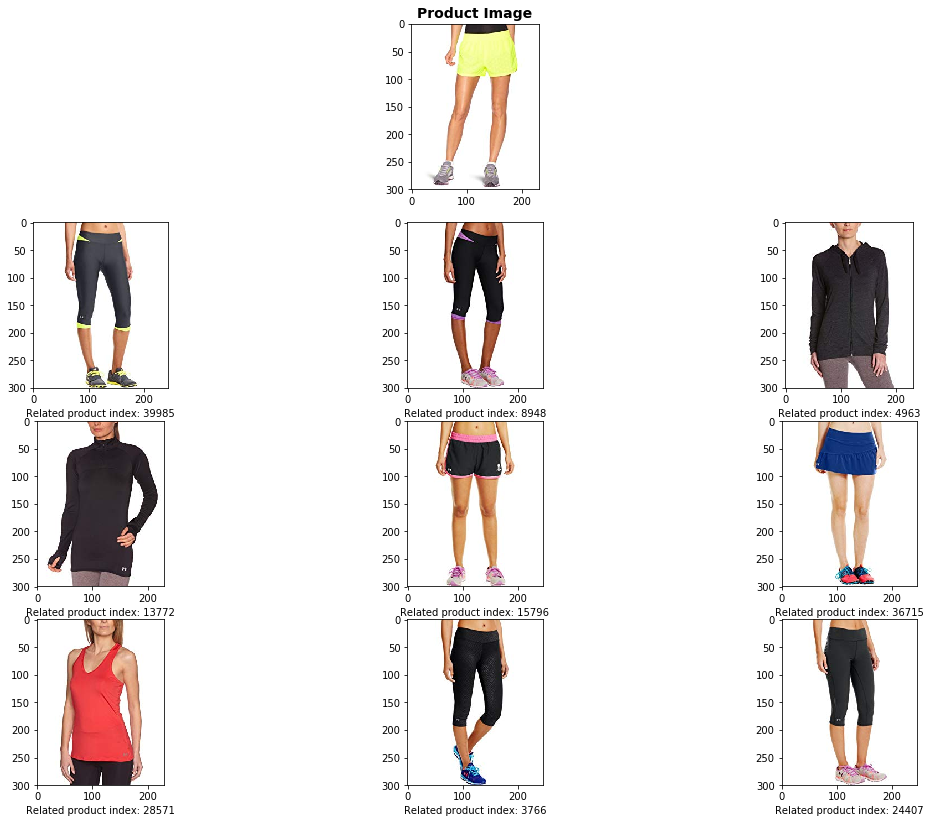

In [34]:
get_related_products(31556)

And that wasn't even hard to call! We do get recommendations of ther Harry Potter merchandize.

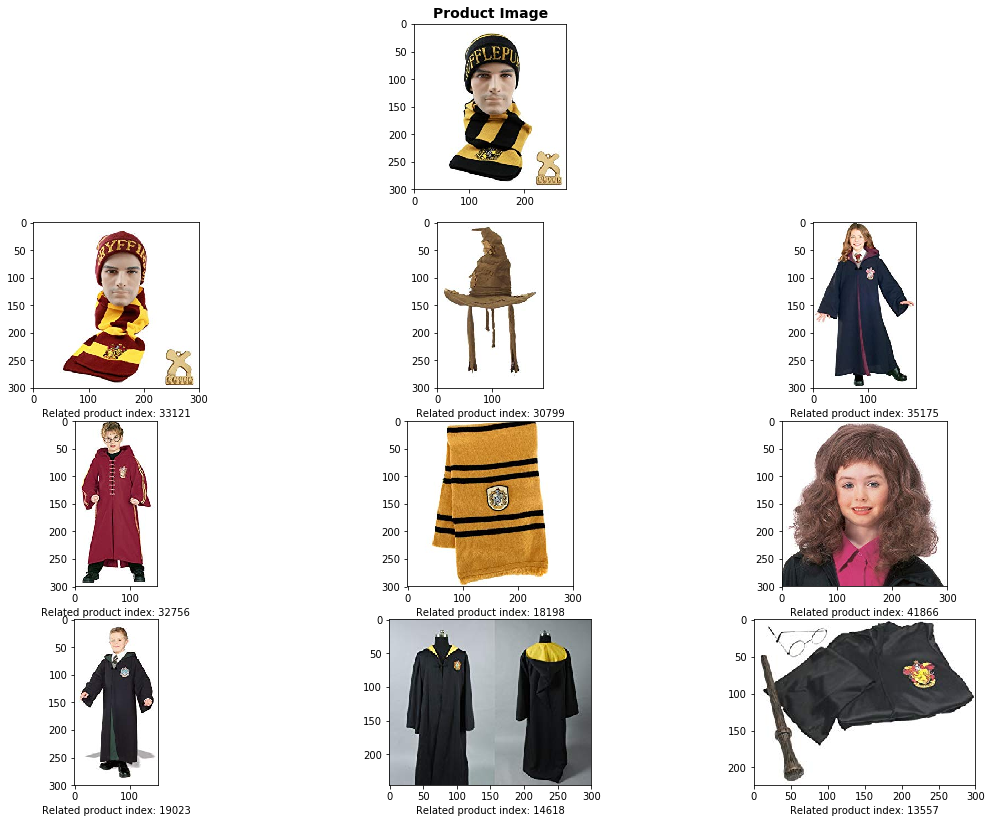

In [35]:
get_related_products(23854)

In [49]:
new_df['description'].loc[14124]

'Angry Birds Baseball Cap Kids Size Hat Adjustable Velcro Closure on Back 1 Size Fits Most Kids (Head Girth Max Approximately 21 Inches)'

We have a **baseball cap** from **Angry Birds**

And we get other products from the **Angry Birds** merchandize.

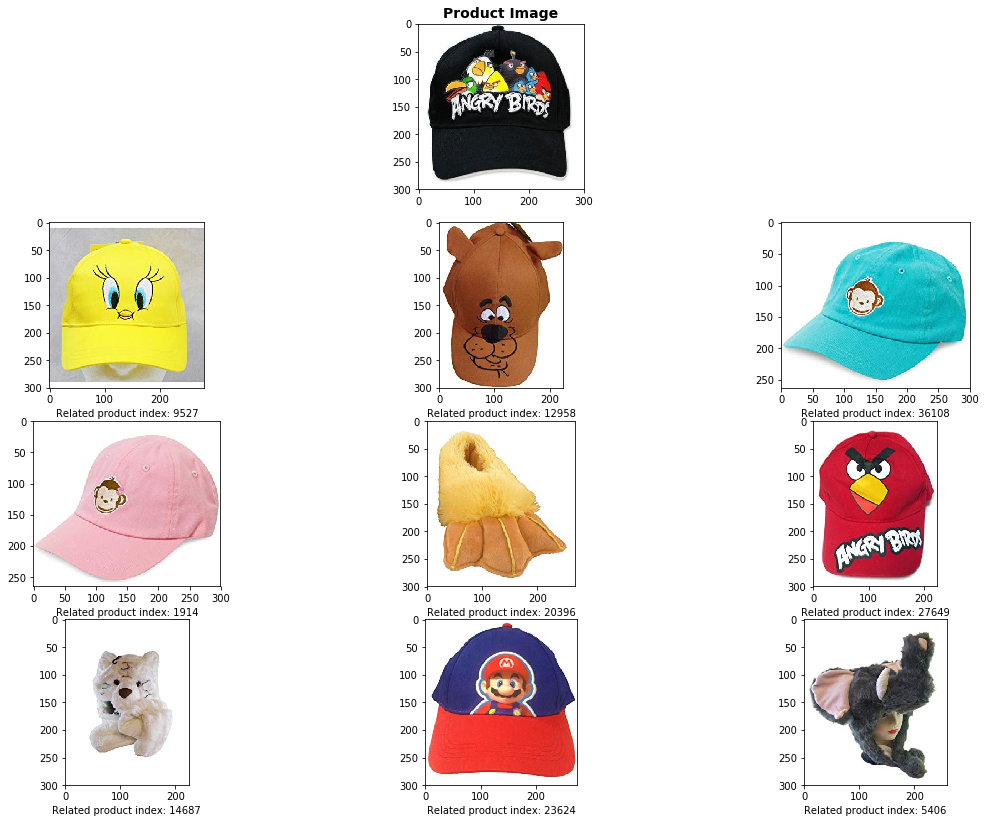

In [36]:
get_related_products(13873)

We have **socks** from Superman! Let's checkout the results!

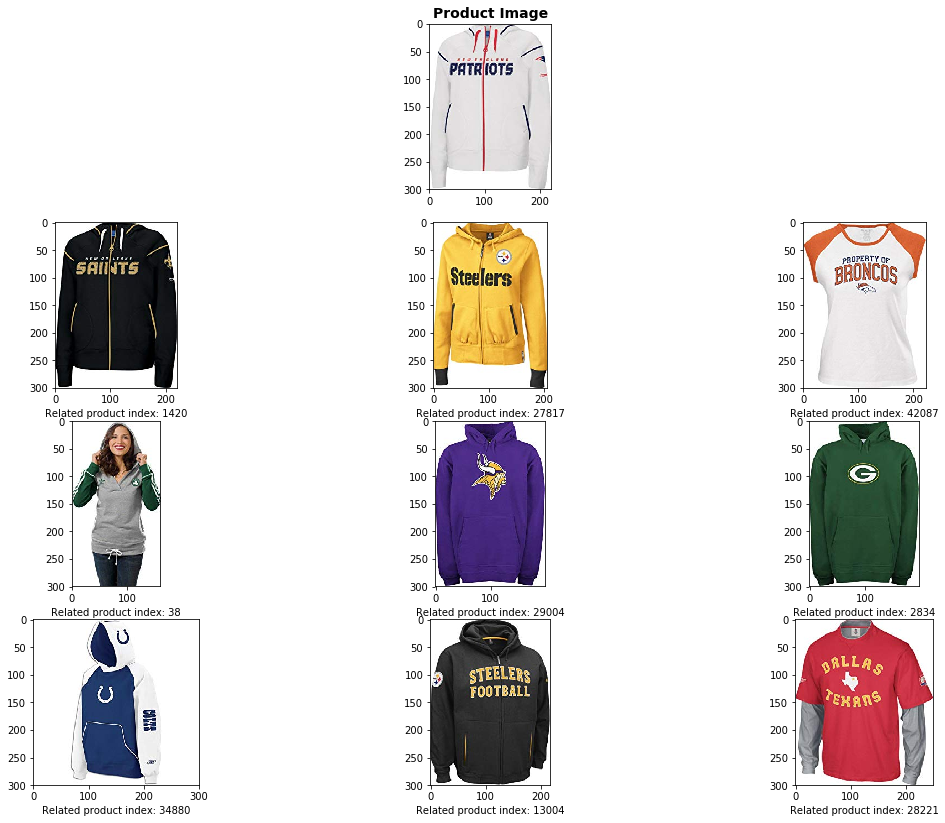

In [37]:
get_related_products(12044)

Indeed, we get recommendations of other **Superman** products.

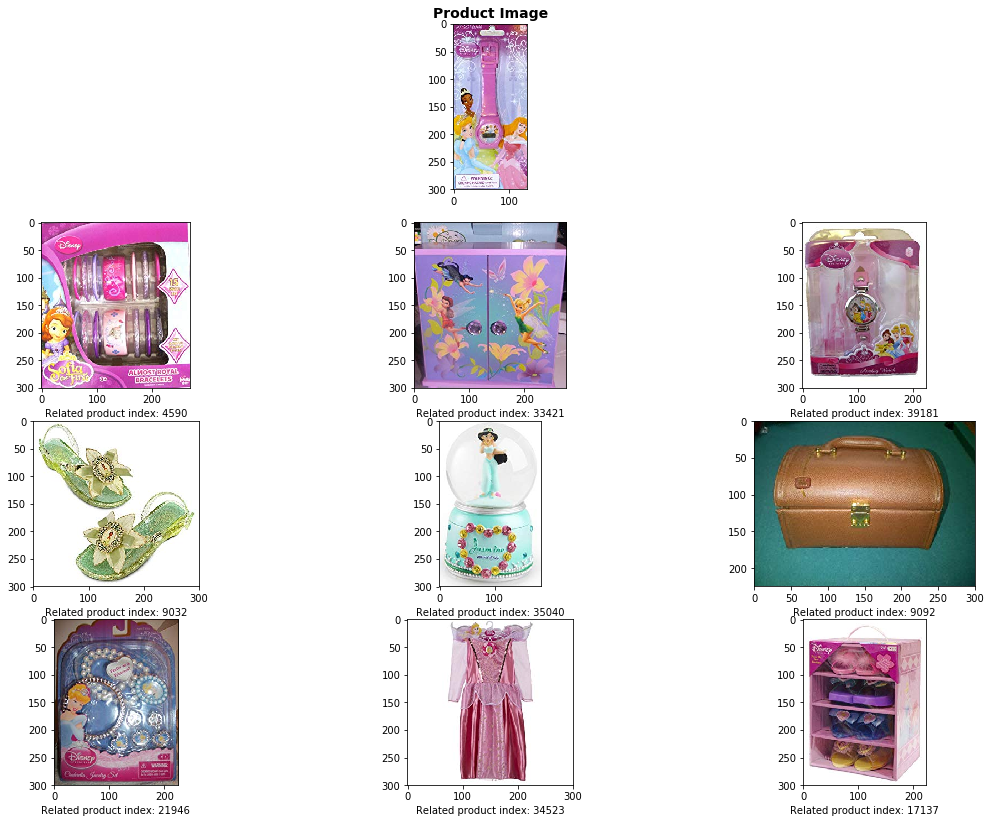

In [38]:
get_related_products(13388)

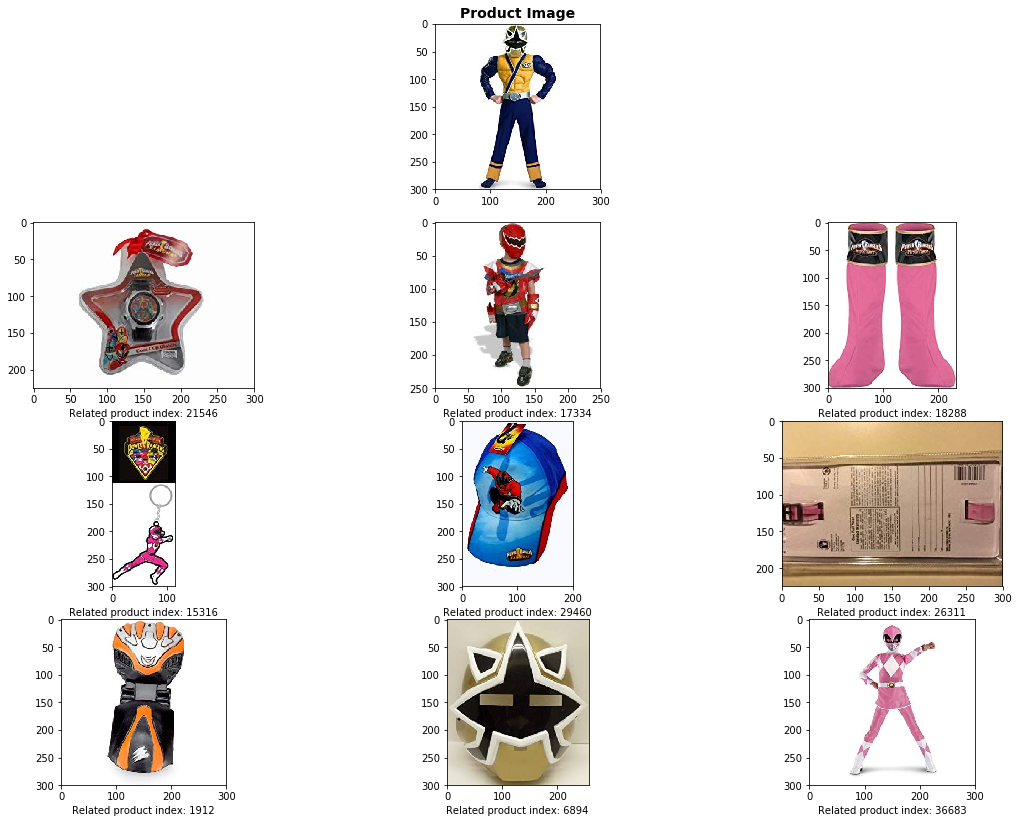

In [39]:
get_related_products(31224)

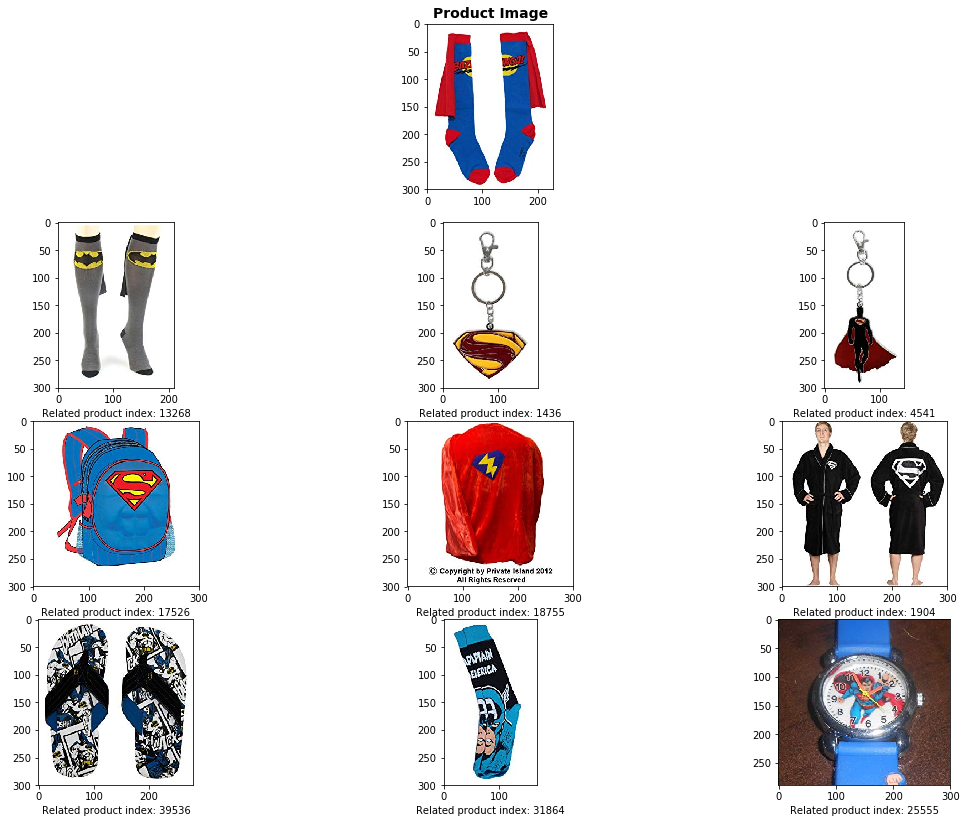

In [40]:
get_related_products(2014)

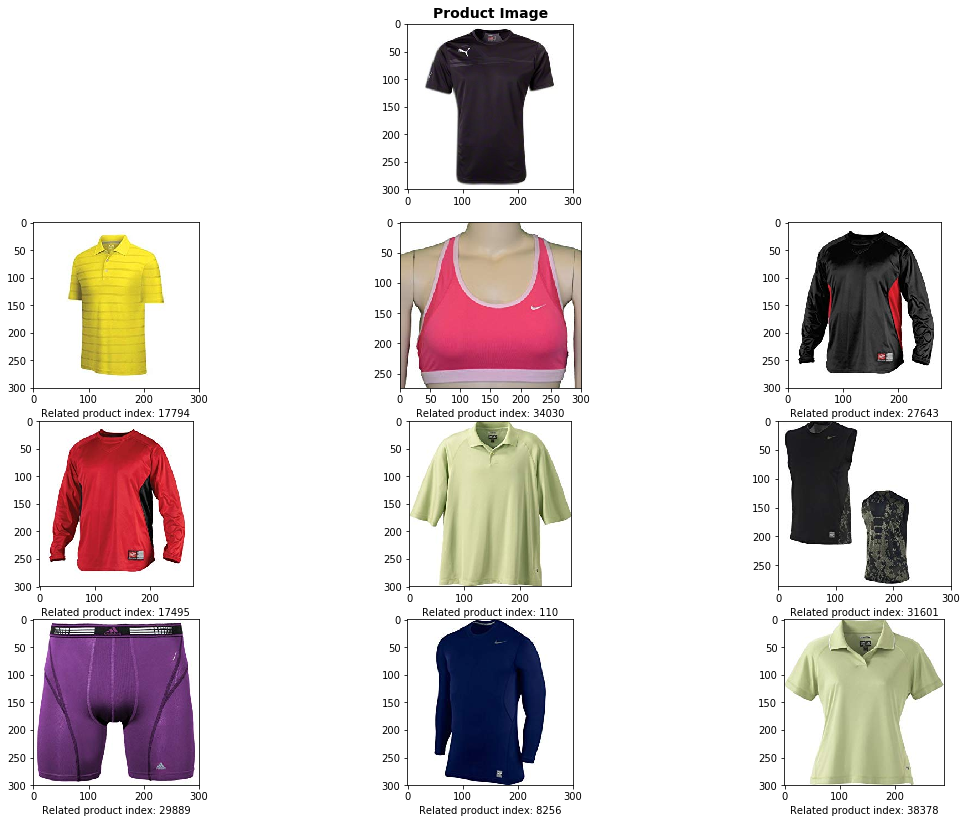

In [41]:
get_related_products(40391)

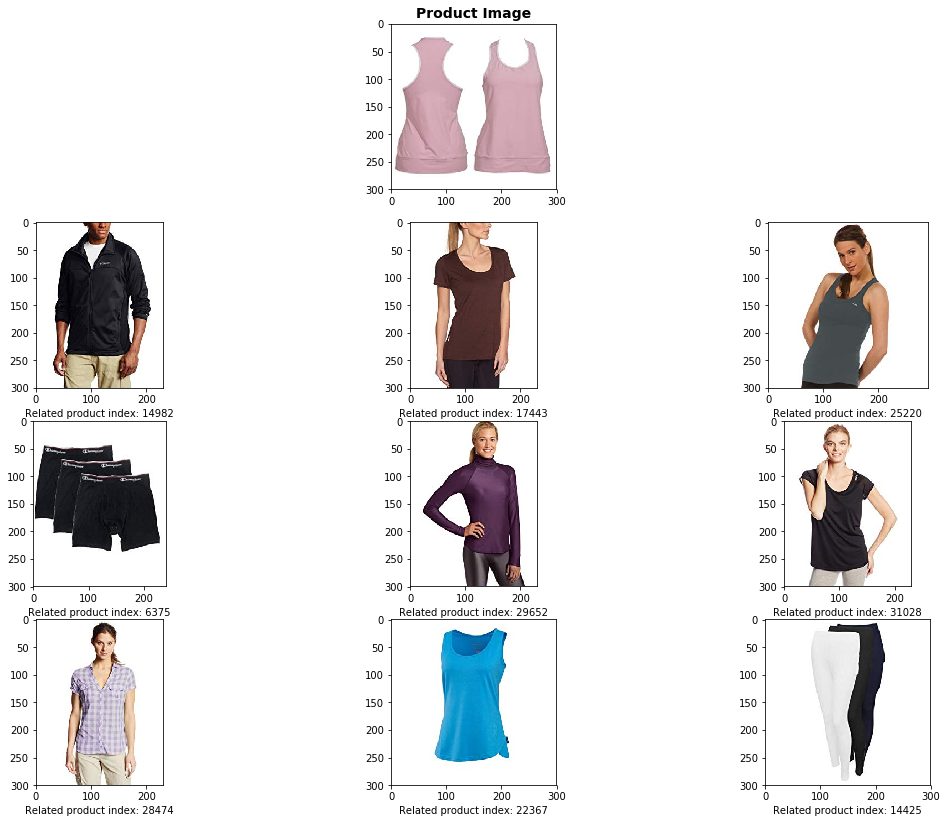

In [42]:
get_related_products(42516)